# Predict acceptance to each enterprise

#### Key feature
- Correlation analysis between algo types & feature selection
- Dimensionality Reduction using Truncated Singlular Value Decomposition (SVD) (to 2D)
- Normalize feature to Bivariate Normal Distribution & Visualize
- Build Linear Model for acceptance prediction
- Calculate the Probability that each user will be accepted to each company & Save

### Configurations

In [1]:
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s',

    datefmt='%Y-%m-%d,%H:%M:%S:%f', level=logging.INFO)

In [2]:
logging.info('Application Start!!')

2022-06-11,16:13:32:%f INFO Application Start!!


### Get stat company

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark import SparkConf, SparkContext, SQLContext

conf = SparkConf().setMaster("yarn").setAppName("bigdata-group1-predict-acceptance")
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)


In [5]:
from pyspark.sql.types import *
from pyspark.sql import functions as F
company_schema = StructType([
    StructField("company", StringType()),
    StructField("type", StringType()),
    StructField("count", IntegerType()),
    StructField("avg_of_difficulty", FloatType())
])

In [6]:
company_df = sqlContext.read.format("csv").option("encoding", "UTF-8").schema(company_schema).load("static/stat_enterprise/stat_each_enterprise")

### Get stat user

In [7]:
user_schema = StructType([
    StructField("user", StringType()),
    StructField("user_rank", StringType()),
    StructField("type", StringType()),
    StructField("total_submit", IntegerType()),
    StructField("correct", IntegerType()),
    StructField("wrong", IntegerType()),
    StructField("correct_rate", FloatType())
])

In [8]:
user_df = sqlContext.read.format("csv").option("encoding", "UTF-8").schema(user_schema).load("static/stat_correct/algo_correct_stat_user")
user_df.show()

+-----------+---------+-------------------+------------+-------+-----+------------+
|       user|user_rank|               type|total_submit|correct|wrong|correct_rate|
+-----------+---------+-------------------+------------+-------+-----+------------+
|sonsh011106|   실버 2|다이나믹 프로그래밍|          49|     19|   30|   0.3877551|
|sonsh011106|   실버 2|          두 포인터|          11|      4|    7|  0.36363637|
|sonsh011106|   실버 2|               재귀|           3|      1|    2|  0.33333334|
|sonsh011106|   실버 2|        그래프 탐색|           2|      0|    2|         0.0|
|sonsh011106|   실버 2|        그래프 이론|           2|      0|    2|         0.0|
|    sonsh04|   UNRANK|               구현|          12|     10|    2|   0.8333333|
|    sonsh04|   UNRANK|           사칙연산|           9|      7|    2|   0.7777778|
|    sonsh04|   UNRANK|               수학|           9|      7|    2|   0.7777778|
|  sonsh5364|   실버 3|         시뮬레이션|           1|      1|    0|         1.0|
|  sonsh5364|   실버 3|        그래프 탐색|      

### Get stat problem

In [37]:
problem_schema = StructType([
    StructField("type", StringType()),
    StructField("count", IntegerType()),
    StructField("avg_of_difficulty", FloatType())
])

In [39]:
problem_df = sqlContext.read.format("csv").option("encoding", "UTF-8").schema(problem_schema).load("static/problem/problem_avg_difficulty")
problem_df.show()

+-------------------------------------+-----+-----------------+
|                                 type|count|avg_of_difficulty|
+-------------------------------------+-----+-----------------+
|                              애드 혹|  527|        16.702087|
|       트리에서의 다이나믹 프로그래밍|  238|          19.7479|
|              트리를 사용한 집합과 맵|  261|        15.735632|
|                     모듈로 곱셈 역원|   31|        17.129032|
|                             키타마사|    7|        23.571428|
|                       안정 결혼 문제|    5|             20.2|
|                        크누스 최적화|    7|        20.857143|
|비트필드를 이용한 다이나믹 프로그래밍|  185|        18.610811|
|                            분할 정복|  284|        20.112677|
|                             수치해석|   14|        21.142857|
|                               문자열| 1569|         9.866795|
|                  최소 비용 최대 유량|   72|        21.430555|
|                      센트로이드 분할|   47|         23.51064|
|                            현 그래프|    2|             24.5|
|        

# Preprocessing for EDA

In [9]:
company_df.groupBy("company").count().show()

+-------+-----+
|company|count|
+-------+-----+
|coupang|   44|
|  naver|   48|
|  kakao|   27|
|samsung|   18|
|   line|   56|
+-------+-----+



In [389]:
company_name_rows = company_df.groupBy("company").count().select("company").collect()
companys = list(map(lambda x: x[0], company_name_rows))

In [390]:
company_stat = []

In [379]:
company_df.filter(F.col("company") == "line").sort(F.col("count").desc()).head(10)

In [11]:
company_df.filter(F.col("company") == "kakao").sort(F.col("count").desc()).head(10)

[Row(company='kakao', type='구현', count=16, avg_of_difficulty=10.1875),
 Row(company='kakao', type='문자열', count=12, avg_of_difficulty=10.333333015441895),
 Row(company='kakao', type='브루트포스', count=9, avg_of_difficulty=11.55555534362793),
 Row(company='kakao', type='그래프 이론', count=8, avg_of_difficulty=12.875),
 Row(company='kakao', type='너비 우선 탐색', count=5, avg_of_difficulty=14.0),
 Row(company='kakao', type='깊이 우선 탐색', count=5, avg_of_difficulty=14.199999809265137),
 Row(company='kakao', type='다이나믹 프로그래밍', count=5, avg_of_difficulty=15.800000190734863),
 Row(company='kakao', type='해시', count=4, avg_of_difficulty=13.0),
 Row(company='kakao', type='자료구조', count=4, avg_of_difficulty=13.25),
 Row(company='kakao', type='다익스트라', count=3, avg_of_difficulty=14.666666984558105)]

In [12]:
company_df.filter(F.col("company") == "naver").sort(F.col("count").desc()).head(10)

[Row(company='naver', type='구현', count=23, avg_of_difficulty=9.34782600402832),
 Row(company='naver', type='자료 구조', count=16, avg_of_difficulty=13.1875),
 Row(company='naver', type='문자열', count=15, avg_of_difficulty=8.533333778381348),
 Row(company='naver', type='브루트포스 알고리즘', count=11, avg_of_difficulty=11.909090995788574),
 Row(company='naver', type='수학', count=11, avg_of_difficulty=10.181818008422852),
 Row(company='naver', type='백트래킹', count=8, avg_of_difficulty=12.0),
 Row(company='naver', type='그래프 탐색', count=7, avg_of_difficulty=12.0),
 Row(company='naver', type='정렬', count=7, avg_of_difficulty=11.428571701049805),
 Row(company='naver', type='두 포인터', count=7, avg_of_difficulty=11.0),
 Row(company='naver', type='그래프 이론', count=7, avg_of_difficulty=12.0)]

In [13]:
company_df.filter(F.col("company") == "samsung").sort(F.col("count").desc()).head(10)

[Row(company='samsung', type='구현', count=45, avg_of_difficulty=12.422222137451172),
 Row(company='samsung', type='시뮬레이션', count=36, avg_of_difficulty=12.777777671813965),
 Row(company='samsung', type='브루트포스 알고리즘', count=19, avg_of_difficulty=11.0),
 Row(company='samsung', type='그래프 이론', count=13, avg_of_difficulty=12.461538314819336),
 Row(company='samsung', type='너비 우선 탐색', count=11, avg_of_difficulty=12.363636016845703),
 Row(company='samsung', type='그래프 탐색', count=11, avg_of_difficulty=12.363636016845703),
 Row(company='samsung', type='백트래킹', count=8, avg_of_difficulty=10.875),
 Row(company='samsung', type='깊이 우선 탐색', count=5, avg_of_difficulty=12.199999809265137),
 Row(company='samsung', type='다이나믹 프로그래밍', count=2, avg_of_difficulty=11.0),
 Row(company='samsung', type='자료 구조', count=2, avg_of_difficulty=13.0)]

In [14]:
company_df.filter(F.col("company") == "coupang").sort(F.col("count").desc()).head(10)

[Row(company='coupang', type='문자열', count=22, avg_of_difficulty=10.363636016845703),
 Row(company='coupang', type='구현', count=20, avg_of_difficulty=10.699999809265137),
 Row(company='coupang', type='자료 구조', count=12, avg_of_difficulty=12.25),
 Row(company='coupang', type='수학', count=11, avg_of_difficulty=13.0),
 Row(company='coupang', type='그래프 탐색', count=10, avg_of_difficulty=15.699999809265137),
 Row(company='coupang', type='그래프 이론', count=10, avg_of_difficulty=15.699999809265137),
 Row(company='coupang', type='깊이 우선 탐색', count=8, avg_of_difficulty=15.25),
 Row(company='coupang', type='해시를 사용한 집합과 맵', count=7, avg_of_difficulty=9.428571701049805),
 Row(company='coupang', type='파싱', count=7, avg_of_difficulty=12.714285850524902),
 Row(company='coupang', type='브루트포스 알고리즘', count=7, avg_of_difficulty=11.571428298950195)]

In [391]:
for company in companys:
    top5_rows = company_df.filter(F.col("company") == company).sort(F.col("count").desc()).head(5)
    company_stat.append({"company": company, "top1": top5_rows[0][1], "top2": top5_rows[1][1], "top3": top5_rows[2][1], "top4": top5_rows[3][1], "top5": top5_rows[4][1]})

In [394]:
company_stat_df = sqlContext.createDataFrame(company_stat)
company_stat_df.show()

+-------+------+-------------------+-------------------+-------------------+--------------+
|company|  top1|               top2|               top3|               top4|          top5|
+-------+------+-------------------+-------------------+-------------------+--------------+
|coupang|문자열|               구현|          자료 구조|               수학|   그래프 탐색|
|  naver|  구현|          자료 구조|             문자열|브루트포스 알고리즘|          수학|
|  kakao|  구현|             문자열|         브루트포스|        그래프 이론|너비 우선 탐색|
|samsung|  구현|         시뮬레이션|브루트포스 알고리즘|        그래프 이론|   그래프 탐색|
|   line|  구현|브루트포스 알고리즘|             문자열|          자료 구조|          수학|
+-------+------+-------------------+-------------------+-------------------+--------------+



In [397]:
# 브루트포스 알고리즘 == 브루트포스
for i in range(1, 6):
    col = "top{}".format(str(i))
    company_stat_df = company_stat_df.withColumn(col, F.when(F.col(col) == "브루트포스", "브루트포스 알고리즘").otherwise(F.col(col)))
company_stat_df.show() 

+-------+------+-------------------+-------------------+-------------------+--------------+
|company|  top1|               top2|               top3|               top4|          top5|
+-------+------+-------------------+-------------------+-------------------+--------------+
|coupang|문자열|               구현|          자료 구조|               수학|   그래프 탐색|
|  naver|  구현|          자료 구조|             문자열|브루트포스 알고리즘|          수학|
|  kakao|  구현|             문자열|브루트포스 알고리즘|        그래프 이론|너비 우선 탐색|
|samsung|  구현|         시뮬레이션|브루트포스 알고리즘|        그래프 이론|   그래프 탐색|
|   line|  구현|브루트포스 알고리즘|             문자열|          자료 구조|          수학|
+-------+------+-------------------+-------------------+-------------------+--------------+



In [17]:
import itertools
test_top10_bank = {"line": [], "coupang": [], "naver": [], "kakao": [], "samsung": []}
for company in test_top10_bank.keys():
    for row in company_df.filter(F.col("company") == company).sort(F.col("count").desc()).head(10):
        test_top10_bank[company].append(row[1])

test_bank = set(list(itertools.chain(*test_top10_bank.values())))
test_bank

{'구현',
 '그래프 이론',
 '그래프 탐색',
 '그리디 알고리즘',
 '깊이 우선 탐색',
 '너비 우선 탐색',
 '다이나믹 프로그래밍',
 '다익스트라',
 '두 포인터',
 '문자열',
 '백트래킹',
 '브루트포스',
 '브루트포스 알고리즘',
 '수학',
 '시뮬레이션',
 '자료 구조',
 '자료구조',
 '정렬',
 '파싱',
 '해시',
 '해시를 사용한 집합과 맵'}

In [21]:
algo_df = user_df.filter(F.col("type").isin(test_bank)).groupBy("type").agg(F.sum("total_submit").alias("total_submit") \
                                                              ,F.sum("correct").alias("correct") \
                                                              ,F.sum("wrong").alias("wrong"))

In [36]:
algo_df.filter((F.col("type") == "브루트포스 알고리즘") |  (F.col("type") == "해시를 사용한 집합과 맵") | (F.col("type") == "자료구조")).show()

+-----------------------+------------+-------+------+
|                   type|total_submit|correct| wrong|
+-----------------------+------------+-------+------+
|해시를 사용한 집합과 맵|       55662|  28627| 27035|
|    브루트포스 알고리즘|      388907| 200805|188102|
+-----------------------+------------+-------+------+



In [40]:
test_bank_deduplicate_df = test_bank - set(["브루트포스 알고리즘", "해시를 사용한 집합과 맵", "자료구조"])
brute = algo_df.filter(F.col("type") == "브루트포스 알고리즘").head()
hashed = algo_df.filter(F.col("type") == "해시를 사용한 집합과 맵").head()

In [44]:
test_bank_df = algo_df.filter(F.col("type").isin(test_bank_deduplicate_df)) \
   .withColumn("total_submit", F.when(F.col("type") == "브루트포스", F.col("total_submit") + brute[1]) \
               .when(F.col("type") == "해시", F.col("total_submit") + hashed[1]) \
               .otherwise(F.col("total_submit"))) \
   .withColumn("correct", F.when(F.col("type") == "브루트포스", F.col("correct") + brute[2]) \
               .when(F.col("type") == "해시", F.col("correct") + hashed[2]) \
               .otherwise(F.col("correct"))) \
    .withColumn("wrong", F.when(F.col("type") == "브루트포스", F.col("wrong") + brute[3]) \
               .when(F.col("type") == "해시", F.col("wrong") + hashed[3]) \
               .otherwise(F.col("wrong"))) \
    .withColumn("correct_rate", F.col("correct") / F.col("total_submit"))

In [46]:
joined_bank_df = test_bank_df.join(problem_df.select("type", "avg_of_difficulty"), ["type"], "left_outer")

# Dimensonality Reduction

## Correlation

In [57]:
transposed_bank_df = sqlContext.createDataFrame(joined_bank_df.toPandas().set_index("type").transpose())

In [69]:
transposed_bank_pd = joined_bank_df.toPandas().set_index("type").transpose()
transposed_bank_pd.corr()


type,다익스트라,다이나믹 프로그래밍,그래프 탐색,구현,파싱,수학,깊이 우선 탐색,너비 우선 탐색,그래프 이론,그리디 알고리즘,두 포인터,문자열,백트래킹,자료 구조,시뮬레이션,정렬
type,,,,,,,,,,,,,,,,
다익스트라,1.000000,0.988020,0.993974,0.920017,0.989428,0.945196,0.987721,0.992501,0.994437,0.990049,0.999600,0.957273,0.963842,0.992050,0.977442,0.988502
다이나믹 프로그래밍,0.988020,1.000000,0.998983,0.969471,0.999956,0.984260,0.999998,0.999475,0.998779,0.999905,0.991992,0.990433,0.993419,0.999586,0.998326,0.999995
그래프 탐색,0.993974,0.998983,1.000000,0.957429,0.999363,0.975290,0.998894,0.999919,0.999991,0.999508,0.996678,0.983204,0.987244,0.999867,0.994703,0.999120
구현,0.920017,0.969471,0.957429,1.000000,0.967122,0.997546,0.969942,0.961020,0.956176,0.966009,0.930737,0.994033,0.991177,0.962017,0.982029,0.968693
파싱,0.989428,0.999956,0.999363,0.967122,1.000000,0.982554,0.999936,0.999736,0.999200,0.999991,0.993136,0.989091,0.992297,0.999813,0.997738,0.999980
수학,0.945196,0.984260,0.975290,0.997546,0.982554,1.000000,0.984598,0.978019,0.974329,0.981737,0.954056,0.999231,0.998024,0.978769,0.992833,0.983697
깊이 우선 탐색,0.987721,0.999998,0.998894,0.969942,0.999936,0.984598,1.000000,0.999411,0.998682,0.999877,0.991747,0.990697,0.993637,0.999529,0.998436,0.999987
너비 우선 탐색,0.992501,0.999475,0.999919,0.961020,0.999736,0.978019,0.999411,1.000000,0.999855,0.999826,0.995562,0.985444,0.989187,0.999993,0.995929,0.999572
그래프 이론,0.994437,0.998779,0.999991,0.956176,0.999200,0.974329,0.998682,0.999855,1.000000,0.999364,0.997019,0.982408,0.986549,0.999787,0.994251,0.998930


In [73]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

/home/hadoop/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hadoop/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hadoop/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hadoop/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hadoop/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46972 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hadoop/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51

<AxesSubplot:xlabel='type', ylabel='type'>

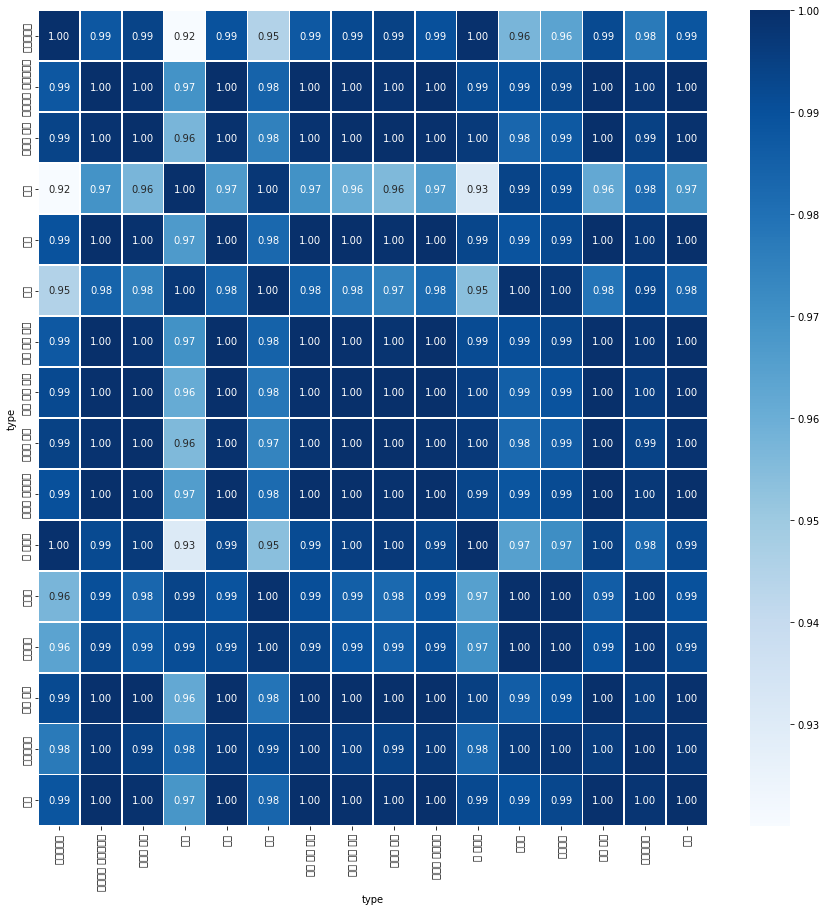

In [74]:
plt.figure(figsize=(15,15))
sns.heatmap(data = transposed_bank_pd.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

## Feature Selection

In [79]:
user_grouped_df = user_df.groupBy("user").agg(F.collect_list("type"), F.collect_list("total_submit"), F.collect_list("correct"), F.collect_list("wrong"), F.collect_list("correct_rate"))
user_grouped_df.printSchema()

root
 |-- user: string (nullable = true)
 |-- collect_list(type): array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- collect_list(total_submit): array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- collect_list(correct): array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- collect_list(wrong): array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- collect_list(correct_rate): array (nullable = true)
 |    |-- element: float (containsNull = true)



In [107]:
def line_rate(type_list, rate_list):
    line_top5=["구현", "브루트포스 알고리즘", "문자열", "자료 구조", "수학"]
    ret = []
    for _type in line_top5:
        if _type in type_list:
            ret.append(rate_list[type_list.index(_type)])
        else:
            ret.append(0.0)
    return ret


In [108]:
line_rate_udf = F.udf(line_rate, ArrayType(FloatType()))

In [112]:
line_merged_df = user_grouped_df.select("user", line_rate_udf(F.col("collect_list(type)"), F.col("collect_list(correct_rate)")).alias("merged"))
user_line_df = line_merged_df.withColumn("구현", F.col("merged")[0]) \
    .withColumn("브루트포스 알고리즘", F.col("merged")[1]) \
    .withColumn("문자열", F.col("merged")[2]) \
    .withColumn("자료 구조", F.col("merged")[3]) \
    .withColumn("수학", F.col("merged")[4]).drop("merged")
user_line_df.show()

+-------------+----------+-------------------+----------+----------+----------+
|         user|      구현|브루트포스 알고리즘|    문자열| 자료 구조|      수학|
+-------------+----------+-------------------+----------+----------+----------+
|      1223hyo|0.51428574|                0.0|       0.0|       0.0|       0.5|
|      1998phy|      0.75|                0.5|       0.5|      0.25|0.45454547|
|     1dilumn0| 0.5652174|         0.37209302|0.39130434|0.39215687|       0.6|
|      1x2x257|       0.0|                0.0|       0.0|       0.0| 0.8333333|
|     20201785|0.71428573|                1.0|       0.0|       0.0|       0.5|
|      2david2|0.80487806|                0.0|0.54545456|       0.0|0.61764705|
|4vm89092n7890|       1.0|                0.0|       1.0|       0.0|       1.0|
|      5gkfka5| 0.8333333|         0.33333334|       0.0|0.26666668|       0.6|
|       aa4060|0.33333334|                0.0|       0.0|       0.0|       0.3|
|   aaabbb4202|       0.0|                0.0|       0.0|   

In [235]:
id_line_df = user_line_df.withColumn("id", F.monotonically_increasing_id())

## Dimensionality Reduction using Truncated Singlular Value Decomposition (5D->2D)

In [371]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix, DenseMatrix
from pyspark.ml.feature import VectorAssembler


vecAssembler = VectorAssembler(inputCols=user_line_df.drop("user").columns, outputCol="features")
vector_df = vecAssembler.transform(user_line_df.drop("user")).select("features")


In [372]:
temp_rdd = vector_df.rdd.map(lambda x: Vectors.fromML(x[0]))

[SparseVector(5, {0: 0.5143, 4: 0.5})]

In [198]:
d_s = DenseMatrix(2, 2, [s[0],0, 0, s[1]])
d_s.toArray()

array([[268.96617001,   0.        ],
       [  0.        , 102.67310255]])

In [373]:
mat = RowMatrix(temp_rdd)
svd = mat.computeSVD(2, computeU=True)

In [374]:
U = svd.U       # Left Singular Vector
s = svd.s       # 2 Singular value
V = svd.V       # Right Singular Vector

In [214]:
truncated_user = U.multiply(d_s).multiply(V_t)
truncated_user.rows.map(lambda x: (x, )).toDF().show(truncate=False)

+------------------------------------------------------------------------------------------------------+
|_1                                                                                                    |
+------------------------------------------------------------------------------------------------------+
|[0.20832575138265413,0.14339042364017968,0.489095439865067,0.12014089951127452,0.3963622498010033]    |
|[0.7170243438631013,0.48431948466957897,0.5834978722106566,0.6711824851995538,0.3854246636150449]     |
|[0.647932654120519,0.43790472237033834,0.5575826072353385,0.599407217854156,0.37525834410582537]      |
|[0.15852300460627455,0.10931316995788444,0.3962927085971556,0.08576877395744298,0.32307269120172144]  |
|[0.6436388145118086,0.43509827146204627,0.5652997061528932,0.5927613707396348,0.3829272028227005]     |
|[0.5159870036652984,0.3509279725751773,0.7066662998174226,0.41581574461203963,0.5325547104889388]     |
|[0.8161009431987407,0.554054923896127,1.00019454435371

In [375]:
import numpy as np
v = V.toArray()
v_t = np.transpose(v)
v_t

array([[-0.59649676, -0.34390417, -0.40351857, -0.22664717, -0.55832371],
       [ 0.39451121, -0.54128007, -0.47990545, -0.38551811,  0.41526297]])

{'company': 'kakao',
 'top1_reflected': 'score2',
 'top2_reflected': 'score1',
 'top3_reflected': 'score1',
 'top4_reflected': 'score1',
 'top5_reflected': 'score2'}

In [239]:
truncated_score_df = U.rows.map(lambda x: {"score1": float(x[0]), "score2": float(x[1])}).toDF().withColumn("id", F.monotonically_increasing_id())

In [243]:
line_scored_df = id_line_df.join(truncated_score_df, "id")
line_scored_df.persist()

DataFrame[id: bigint, user: string, 구현: float, 브루트포스 알고리즘: float, 문자열: float, 자료 구조: float, 수학: float, score1: double, score2: double]

+---+----+----+-------------------+------+---------+----+------+------+
| id|user|구현|브루트포스 알고리즘|문자열|자료 구조|수학|score1|score2|
+---+----+----+-------------------+------+---------+----+------+------+
+---+----+----+-------------------+------+---------+----+------+------+



In [275]:
from pyspark.ml.feature import StandardScaler
assembler_1 = VectorAssembler(inputCols=["score1"],outputCol="vectored_score1")
vectored_df_1 = assembler_1.transform(line_scored_df)
assembler_2 = VectorAssembler(inputCols=["score2"],outputCol="vectored_score2")
vectored_df = assembler_2.transform(vectored_df_1)
vectored_df.select("vectored_score1", "vectored_score2").show(truncate=False)


+------------------------+------------------------+
|vectored_score1         |vectored_score2         |
+------------------------+------------------------+
|[-0.0041346723130510875]|[-1.8365840019368479E-4]|
|[-0.004060063896791902] |[-4.608305899533307E-4] |
|[-0.004966066530773475] |[-9.107137065034617E-4] |
|[0.0]                   |[0.0]                   |
|[-0.0026479857131488493]|[0.004824286092871272]  |
|[-0.003262813488919546] |[0.005989079767576516]  |
|[-0.0035749415369504337]|[0.0065604114561784305] |
|[-0.003624507813647184] |[0.004064016054085769]  |
|[-0.005084874603735277] |[-0.003433330878991991] |
|[-0.005174017866012666] |[-0.002254957141646251] |
|[-0.0027476094724805432]|[-0.002374309207926329] |
|[-0.004579690613519058] |[-0.00646267549415642]  |
|[-4.213302514601373E-4] |[-0.0018774055812634466]|
|[-0.005794718708255582] |[-0.003789692603424755] |
|[-0.002961216920804809] |[0.005450540478021024]  |
|[-0.0032556459071363046]|[0.005864658676621545]  |
|[-0.0044067

In [316]:
scaler_1 = StandardScaler(inputCol="vectored_score1", outputCol="scaled_score1",
                        withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scale_model_1 = scaler_1.fit(vectored_df)

# Normalize each feature to have unit standard deviation.
scaled_1 = scale_model_1.transform(vectored_df)


scaled_1.withColumn("scaled_score1", extract_udf(F.col("scaled_score1"))).select("scaled_score1").describe().show(truncate=False)

+-------+--------------------+
|summary|scaled_score1       |
+-------+--------------------+
|count  |64337               |
|mean   |2.687631130613707E-9|
|stddev |1.0000000081159095  |
|min    |-2.6177993          |
|max    |2.1589222           |
+-------+--------------------+



In [317]:
scaler_2 = StandardScaler(inputCol="vectored_score2", outputCol="scaled_score2",
                        withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scale_model_2 = scaler_2.fit(scaled_1)

# Normalize each feature to have unit standard deviation.
scaled_df = scale_model_2.transform(scaled_1)

scaled_df.withColumn("scaled_score1", extract_udf(F.col("scaled_score1"))) \
    .withColumn("scaled_score2", extract_udf(F.col("scaled_score2"))) \
    .select("scaled_score1", "scaled_score2").describe().show(truncate=False)

+-------+--------------------+----------------------+
|summary|scaled_score1       |scaled_score2         |
+-------+--------------------+----------------------+
|count  |64337               |64337                 |
|mean   |2.687631130613707E-9|-8.237840748820714E-10|
|stddev |1.00000000811591    |0.9999999997615333    |
|min    |-2.6177993          |-3.6584785            |
|max    |2.1589222           |1.8754575             |
+-------+--------------------+----------------------+



In [318]:
extract_udf = F.udf(lambda x: x.tolist()[0], FloatType())
stat_df = scaled_df.withColumn("scaled_score1", extract_udf(F.col("scaled_score1"))) \
    .withColumn("scaled_score2", extract_udf(F.col("scaled_score2"))) \
    .select("user", "scaled_score1", "scaled_score2")
stat_df.select("scaled_score1", "scaled_score2").describe().show(truncate=False)

+-------+--------------------+----------------------+
|summary|scaled_score1       |scaled_score2         |
+-------+--------------------+----------------------+
|count  |64337               |64337                 |
|mean   |2.687631130613707E-9|-8.237840748820714E-10|
|stddev |1.0000000081159095  |0.9999999997615333    |
|min    |-2.6177993          |-3.6584785            |
|max    |2.1589222           |1.8754575             |
+-------+--------------------+----------------------+



In [329]:
test_df = stat_df.withColumn("Z", F.col("scaled_score1") + F.col("scaled_score2")).select("Z").describe().show(truncate=False)

+-------+--------------------+
|summary|Z                   |
+-------+--------------------+
|count  |64337               |
|mean   |4.713122354412475E-9|
|stddev |1.6222895088638696  |
|min    |-4.254494           |
|max    |2.0125961           |
+-------+--------------------+



In [333]:
from scipy.stats import norm
square_root_two = 2 ** (1/2)
inferior_cdf_udf = F.udf(lambda x, y: norm.cdf((x+y) / square_root_two).tolist(), FloatType())
inferior_cdf_df =stat_df.withColumn("inferior", inferior_cdf_udf(F.col("scaled_score1"), F.col("scaled_score2"))) \
    .withColumn("superior", F.lit(1) - F.col("inferior"))
inferior_cdf_df.show()

+-------------+-------------+-------------+-----------+-----------+
|         user|scaled_score1|scaled_score2|   inferior|   superior|
+-------------+-------------+-------------+-----------+-----------+
|    beth_shan|  -0.33633533|  -0.19340631| 0.35398498| 0.64601505|
|    black_203|  -0.29130945|  -0.26445845| 0.34716445| 0.65283555|
|  dongkum0417|  -0.83807826|   -0.3797844| 0.19457525| 0.80542475|
|bokunoeiyuu20|    2.1589222|  -0.14632612|  0.9226494| 0.07735062|
|     ty0603ty|    0.5608738|    1.0903629|  0.8785161| 0.12148392|
|     dozinguy|   0.18982783|    1.3889537| 0.86786747| 0.13213253|
|      dntlr03| 0.0014598591|    1.5354125| 0.86142254| 0.13857746|
|       ech913| -0.028453182|   0.89547026|  0.7300862|  0.2699138|
|      byj9402|   -0.9097784|   -1.0264486|   0.085481|   0.914519|
|       tjaeld|    -0.963576|  -0.72437656| 0.11632454| 0.88367546|
|       esfjge|    0.5007513|  -0.75497204| 0.42867002| 0.57132995|
|  jiholee0627|    -0.604902|   -1.8030106|0.044

In [334]:
selection_ratio = {"line": 0.25, "kakao": 0.15, "samsung": 0.15, "naver": 0.15, "coupang": 0.20}

In [342]:
import scipy.special


def sum_binomial_pdf(p, inverse_k_min, n=100):
    k_min = int(n* (1-inverse_k_min))
    probability = 0.0
    for k in range(k_min, n+1):
        probability += scipy.special.comb(n, k).tolist() * (p ** k) * ((1-p) ** (n-k))
    return probability

sum_binomial_pdf_udf = F.udf(sum_binomial_pdf, FloatType())
inferior_cdf_df.withColumn("acceptance_probability_line", sum_binomial_pdf_udf(F.col("inferior"), F.lit(selection_ratio["line"]))).show()

+-------------+-------------+-------------+-----------+-----------+---------------------------+
|         user|scaled_score1|scaled_score2|   inferior|   superior|acceptance_probability_line|
+-------------+-------------+-------------+-----------+-----------+---------------------------+
|    beth_shan|  -0.33633533|  -0.19340631| 0.35398498| 0.64601505|              7.9419286E-16|
|    black_203|  -0.29130945|  -0.26445845| 0.34716445| 0.65283555|              2.3850674E-16|
|  dongkum0417|  -0.83807826|   -0.3797844| 0.19457525| 0.80542475|              5.6589176E-33|
|bokunoeiyuu20|    2.1589222|  -0.14632612|  0.9226494| 0.07735062|                        1.0|
|     ty0603ty|    0.5608738|    1.0903629|  0.8785161| 0.12148392|                 0.99987984|
|     dozinguy|   0.18982783|    1.3889537| 0.86786747| 0.13213253|                   0.999541|
|      dntlr03| 0.0014598591|    1.5354125| 0.86142254| 0.13857746|                  0.9990533|
|       ech913| -0.028453182|   0.895470

##### naver

In [363]:
def top5_rate(type_list, rate_list, company):
    _enter_top5 = {"line": ["구현", "브루트포스 알고리즘", "문자열", "자료 구조", "수학"],
             "kakao": ["구현", "문자열", "브루트포스 알고리즘", "그래프 이론", "너비 우선 탐색"],
             "naver": ["구현", "자료 구조", "문자열", "브루트포스 알고리즘", "수학"],
             "samsung": ["구현", "시뮬레이션", "브루트포스 알고리즘", "그래프 이론", "너비 우선 탐색"],
             "coupang": ["문자열", "구현", "자료 구조", "수학", "그래프 탐색"]}
    top5 = _enter_top5[company]
    ret = []
    for _type in top5:
        if _type in type_list:
            ret.append(rate_list[type_list.index(_type)])
        else:
            ret.append(0.0)
    return ret

top5_rate_udf = F.udf(top5_rate, ArrayType(FloatType()))



In [364]:
enter_top5 = {"line": ["구현", "브루트포스 알고리즘", "문자열", "자료 구조", "수학"],
             "kakao": ["구현", "문자열", "브루트포스 알고리즘", "그래프 이론", "너비 우선 탐색"],
             "naver": ["구현", "자료 구조", "문자열", "브루트포스 알고리즘", "수학"],
             "samsung": ["구현", "시뮬레이션", "브루트포스 알고리즘", "그래프 이론", "너비 우선 탐색"],
             "coupang": ["문자열", "구현", "자료 구조", "수학", "그래프 탐색"]}

In [350]:
naver_merged_df = user_grouped_df.select("user", top5_rate_udf(F.col("collect_list(type)"), F.col("collect_list(correct_rate)"), F.lit("naver")).alias("merged"))
user_company_df = naver_merged_df.withColumn("구현", F.col("merged")[0]) \
    .withColumn("자료 구조", F.col("merged")[1]) \
    .withColumn("문자열", F.col("merged")[2]) \
    .withColumn("브루트포스 알고리즘", F.col("merged")[3]) \
    .withColumn("수학", F.col("merged")[4]).drop("merged")
user_company_df.show()

+-------------+----------+----------+----------+-------------------+----------+
|         user|      구현| 자료 구조|    문자열|브루트포스 알고리즘|      수학|
+-------------+----------+----------+----------+-------------------+----------+
|      1223hyo|0.51428574|       0.0|       0.0|                0.0|       0.5|
|      1998phy|      0.75|      0.25|       0.5|                0.5|0.45454547|
|     1dilumn0| 0.5652174|0.39215687|0.39130434|         0.37209302|       0.6|
|      1x2x257|       0.0|       0.0|       0.0|                0.0| 0.8333333|
|     20201785|0.71428573|       0.0|       0.0|                1.0|       0.5|
|      2david2|0.80487806|       0.0|0.54545456|                0.0|0.61764705|
|4vm89092n7890|       1.0|       0.0|       1.0|                0.0|       1.0|
|      5gkfka5| 0.8333333|0.26666668|       0.0|         0.33333334|       0.6|
|       aa4060|0.33333334|       0.0|       0.0|                0.0|       0.3|
|   aaabbb4202|       0.0|       0.0|       0.0|            

In [365]:
def sum_binomial_pdf(p, inverse_k_min, n=100):
    k_min = int(n* (1-inverse_k_min))
    probability = 0.0
    for k in range(k_min, n+1):
        probability += scipy.special.comb(n, k).tolist() * (p ** k) * ((1-p) ** (n-k))
    return probability

In [343]:
enter_top5 = {"line": ["구현", "브루트포스 알고리즘", "문자열", "자료 구조", "수학"],
             "kakao": ["구현", "문자열", "브루트포스 알고리즘", "그래프 이론", "너비 우선 탐색"],
             "naver": ["구현", "자료 구조", "문자열", "브루트포스 알고리즘", "수학"],
             "samsung": ["구현", "시뮬레이션", "브루트포스 알고리즘", "그래프 이론", "너비 우선 탐색"],
             "coupang": ["문자열", "구현", "자료 구조", "수학", "그래프 탐색"]}

In [401]:
from scipy.stats import norm
import scipy.special
user_result_df = user_grouped_df.select("user")
company_reflect_stat = []

for idx, cur_company in enumerate(companys):
    company_merged_df = user_grouped_df.select("user", top5_rate_udf(F.col("collect_list(type)"), \
                                                                  F.col("collect_list(correct_rate)"), \
                                                                 F.lit(cur_company)).alias("merged"))
    user_company_df = company_merged_df
    for idx2, algo_type in enumerate(enter_top5[cur_company]):
        user_company_df = user_company_df.withColumn(algo_type, F.col("merged")[idx2])
    user_company_df = user_company_df.drop("merged")
    id_company_df = user_company_df.withColumn("id", F.monotonically_increasing_id())
    vecAssembler = VectorAssembler(inputCols=user_company_df.drop("user").columns, outputCol="features")
    vector_df = vecAssembler.transform(user_company_df.drop("user")).select("features")
    temp_rdd = vector_df.rdd.map(lambda x: Vectors.fromML(x[0]))
    mat = RowMatrix(temp_rdd)
    svd = mat.computeSVD(2, computeU=True)
    U = svd.U       # Left Singular Vector
    s = svd.s       # 2 Singular value
    V = svd.V       # Right Singular Vector
    v = V.toArray()
    v_t = np.transpose(v)
    
    company_stat_dict = {"company": cur_company}
    for i in range(1, 6):
        col = "top{}_reflected".format(str(i))
        company_stat_dict[col] = "score1" if v_t[0][i-1] > v_t[1][i-1] else "score2"
    company_reflect_stat.append(company_stat_dict)
    truncated_score_df = U.rows.map(lambda x: {"score1": float(x[0]), "score2": float(x[1])}).toDF().withColumn("id", F.monotonically_increasing_id())
    company_scored_df = id_company_df.join(truncated_score_df, "id")
    company_scored_df.persist()

    assembler_1 = VectorAssembler(inputCols=["score1"],outputCol="vectored_score1")
    vectored_df_1 = assembler_1.transform(company_scored_df)
    assembler_2 = VectorAssembler(inputCols=["score2"],outputCol="vectored_score2")
    vectored_df = assembler_2.transform(vectored_df_1)
    vectored_df.select("vectored_score1", "vectored_score2").show(truncate=False)

    scaler_1 = StandardScaler(inputCol="vectored_score1", outputCol="scaled_score1",
                        withStd=True, withMean=True)

    # Compute summary statistics by fitting the StandardScaler
    scale_model_1 = scaler_1.fit(vectored_df)

    # Normalize each feature to have unit standard deviation.
    scaled_1 = scale_model_1.transform(vectored_df)


    scaler_2 = StandardScaler(inputCol="vectored_score2", outputCol="scaled_score2",
                        withStd=True, withMean=True)

    # Compute summary statistics by fitting the StandardScaler
    scale_model_2 = scaler_2.fit(scaled_1)

    # Normalize each feature to have unit standard deviation.
    scaled_df = scale_model_2.transform(scaled_1)
    extract_udf = F.udf(lambda x: x.tolist()[0], FloatType())
    stat_df = scaled_df.withColumn("scaled_score1", extract_udf(F.col("scaled_score1"))) \
        .withColumn("scaled_score2", extract_udf(F.col("scaled_score2"))) \
        .select("user", "scaled_score1", "scaled_score2")

    
    square_root_two = 2 ** (1/2)
    inferior_cdf_udf = F.udf(lambda x, y: norm.cdf((x+y) / square_root_two).tolist(), FloatType())
    inferior_cdf_df =stat_df.withColumn("inferior", inferior_cdf_udf(F.col("scaled_score1"), F.col("scaled_score2"))) \
        .withColumn("superior", F.lit(1) - F.col("inferior"))
    
    sum_binomial_pdf_udf = F.udf(sum_binomial_pdf, FloatType())
    probability_df = inferior_cdf_df.withColumn("acceptance_probability", sum_binomial_pdf_udf(F.col("inferior"), F.lit(selection_ratio[cur_company])))
    probability_df = probability_df.withColumnRenamed("scaled_score1", "{}_score1".format(cur_company)) \
    .withColumnRenamed("scaled_score2", "{}_score2".format(cur_company)) \
    .withColumnRenamed("inferior", "{}_inferior".format(cur_company)) \
    .withColumnRenamed("superior", "{}_superior".format(cur_company)) \
    .withColumnRenamed("acceptance_probability", "{}_acceptance_probability".format(cur_company))
    user_result_df = user_result_df.join(probability_df, "user")

+------------------------+------------------------+
|vectored_score1         |vectored_score2         |
+------------------------+------------------------+
|[-0.0035887385268536264]|[-0.0025593632858757123]|
|[-0.00428906618563641]  |[0.0020484613686669925] |
|[-0.004924166576810392] |[0.002444949056315185]  |
|[-6.954213347464919E-4] |[0.0044464346402928664] |
|[-0.0029065771211567847]|[-0.00430643288685729]  |
|[-0.0035815806314026173]|[-0.00535851620928214]  |
|[-0.003924197859702294] |[-0.00586925753322917]  |
|[-0.0035106191450101094]|[-0.005194891527702011] |
|[-0.004884971083929833] |[0.0036871313945320387] |
|[-0.00425423822089985]  |[-0.0020514451855493175]|
|[-0.0029769885817560416]|[0.0032843399054585092] |
|[-0.0041839372399306]   |[0.005948632076419788]  |
|[-4.5561539882101515E-4]|[0.0027016668409451865] |
|[-0.006208517572535631] |[0.007185597708438865]  |
|[-0.003250564223506256] |[-0.00488080132175779]  |
|[-0.003573378487769576] |[-0.005216723113859914] |
|[-0.0043715

In [370]:
user_result_df.show()

+-------------+-----------+-----------+-------------+-------------+---------------------------+------------+------------+--------------+--------------+----------------------------+--------------+--------------+----------------+----------------+------------------------------+--------------+--------------+----------------+----------------+------------------------------+------------+------------+--------------+--------------+----------------------------+
|         user|line_score1|line_score2|line_inferior|line_superior|line_acceptance_probability|kakao_score1|kakao_score2|kakao_inferior|kakao_superior|kakao_acceptance_probability|coupang_score1|coupang_score2|coupang_inferior|coupang_superior|coupang_acceptance_probability|samsung_score1|samsung_score2|samsung_inferior|samsung_superior|samsung_acceptance_probability|naver_score1|naver_score2|naver_inferior|naver_superior|naver_acceptance_probability|
+-------------+-----------+-----------+-------------+-------------+---------------------

In [402]:
user_result_df.write.format("csv").mode('overwrite') \
    .option("encoding", "UTF-8").save("static/predict_acceptance/user_with_probabilities")

In [403]:
company_reflect_df = sqlContext.createDataFrame(company_reflect_stat)
company_stat_df = company_stat_df.join(company_reflect_df, "company")
company_stat_df.show()

+-------+------+-------------------+-------------------+-------------------+--------------+--------------+--------------+--------------+--------------+--------------+
|company|  top1|               top2|               top3|               top4|          top5|top1_reflected|top2_reflected|top3_reflected|top4_reflected|top5_reflected|
+-------+------+-------------------+-------------------+-------------------+--------------+--------------+--------------+--------------+--------------+--------------+
|coupang|문자열|               구현|          자료 구조|               수학|   그래프 탐색|        score2|        score2|        score2|        score2|        score2|
|  naver|  구현|          자료 구조|             문자열|브루트포스 알고리즘|          수학|        score2|        score1|        score1|        score1|        score2|
|  kakao|  구현|             문자열|브루트포스 알고리즘|        그래프 이론|너비 우선 탐색|        score2|        score2|        score2|        score1|        score1|
|samsung|  구현|         시뮬레이션|브루트포스 알고리즘|        그래프 이론|   그

In [404]:
company_stat_df.write.format("csv").mode('overwrite') \
    .option("encoding", "UTF-8").save("static/predict_acceptance/company_top5_score_criteria")

In [405]:
sc.stop()